# Notebook to train CNNs

In [1]:
import tensorflow as tf
import os

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

# Load libraries
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import math
import time
from pathlib import Path
from Resnet3D_model import Resnet3DBuilder
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, accuracy_score, recall_score
from data_utils import get_paths_and_labels, calculate_min_max, create_dataset, clean_zone_identifier_files, extract_subject_id
from plotting_utils import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedGroupKFold
import gc

2025-05-06 22:41:15.842514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-06 22:41:16.352660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1 Physical GPUs, 1 Logical GPUs


2025-05-06 22:41:17.474105: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-06 22:41:17.500830: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-06 22:41:17.500884: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-06 22:41:17.503529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-06 22:41:17.503573: I external/local_xla/xla/stream_executor

In [2]:
# Set seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# Set mixed precision policy to 'mixed_float16'
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print('Mixed precision policy set to:', policy.name)

Mixed precision policy set to: mixed_float16


In [4]:
NORMALIZATION = "mni_reg_CV" # Choose intensity normalization method: "minmax"
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 4 # Set batch size

USE_MASK = False # Set to True to use the ROI mask, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
else:
    ROI_MASK_PATH = None

# Get train paths and labels to calculate minmax values
train_paths, train_labels_list, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels_list)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataset(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max, 
    mask_path=ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataset(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train...
Found 575 files for class 'smci'
Found 314 files for class 'pmci'
Calculating minmax across 889 files...
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Shuffling with buffer size: 889

No mask applied.

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test...
Found 143 files for class 'smci'
Found 78 files for class 'pmci'

No mask applied.



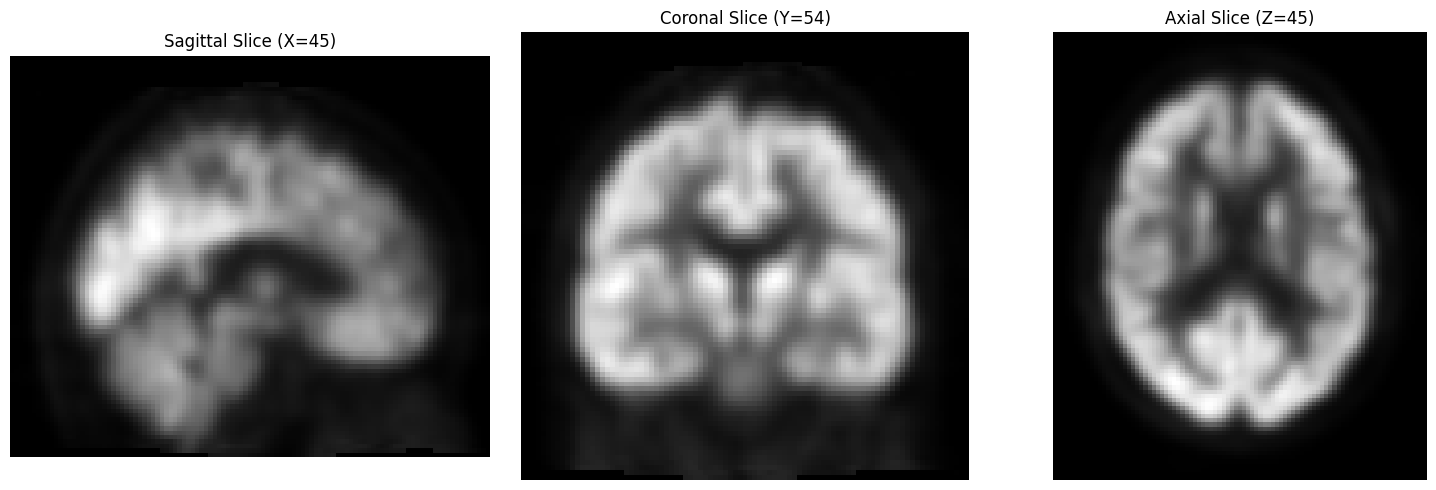

In [5]:
# Verify data with a test sample
for data, label in test_data:
    view_image_data(data[0])
    break

In [6]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation
NUM_EPOCHS = 150 # Number of epochs for training
DROPOUT_RATE = 0.0 # Dropout rate for the model

# para cosine decay
#learning_rates_to_try = [5e-4, 2e-4, 1e-4] # adicionar 1e-3? ver os resultados
#reg_factors_to_try = [5e-4, 2e-4, 1e-4]

#para fixed_lr
#learning_rates_to_try = [1e-5, 2e-5] # adicionar 4e-5 ou 5e-6 dependendo dos resultados
#reg_factors_to_try = [2e-4, 1e-4] # adicionar 4e-4 ou 5e-5 dependendo dos resultados

lr_scheduler = "fixed_lr" # Choose between "cosine_decay" or "fixed_lr"

learning_rates_to_try = [1e-4]
reg_factors_to_try = [2e-4]

if lr_scheduler == "cosine_decay":
    EARLY_STOP_PATIENCE = 100 # we use 20 to mitigate the effect of lucky steps at the beginning of the cosine decay
elif lr_scheduler == "fixed_lr":
    # Use fixed learning rate
    EARLY_STOP_PATIENCE = 60 # we use 10 because with lower learning rates the model converges with more stability
else:
    raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")

tuning_results = []
total_combinations = len(learning_rates_to_try) * len(reg_factors_to_try)
current_combination_no = 0

if ROI_MASK_PATH is None:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/full_brain/cosine_decay/CROSS_VALIDATION/results_resnet34/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/full_brain/fixed_lr/CROSS_VALIDATION/results_resnet34/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")
else:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/masked/cosine_decay/CROSS_VALIDATION/results_resnet34/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/masked/fixed_lr/CROSS_VALIDATION/results_resnet34/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

print("\nStarting Hyperparameter Tuning Grid Search...")
overall_start_time = time.time()

# Hyperparameter tuning loop
for current_lr in learning_rates_to_try:
    for current_reg in reg_factors_to_try:
        current_combination_no += 1
        print("=" * 60)
        print(f"Testing Combination {current_combination_no}/{total_combinations}: LR={current_lr:.1e}, L2_Reg={current_reg:.0e}")
        print("=" * 60)
        start_time_combination = time.time()
        
        combo_dir_name = f"LR0_{current_lr:.1e}_L2_{current_reg:.0e}"
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")
        
        # Store results for the current hyperparameter combination
        current_combo_losses = []
        current_combo_accuracies = []
        current_combo_aucs = []
        current_combo_best_epoch = []

        # Store results for each fold
        fold_val_losses = []
        fold_val_accuracies = []
        fold_val_aucs = []
        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and Reg={current_reg:.0e}...")
            start_time_fold = time.time()

            # Get the paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify that the training and validation sets have no overlapping subjects
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")
                
            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataset(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )
            
            # Create fold validation dataset
            fold_val_data = create_dataset(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )

            if fold_train_data is None or fold_val_data is None:
                raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")

            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            fold_class_weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=fold_train_labels)
            fold_class_weight_dict = dict(zip(unique_classes, fold_class_weights))
            print(f"  Fold Class Weights: {fold_class_weight_dict}")

            tf.keras.backend.clear_session()
            # Build the model
            model = Resnet3DBuilder.build_resnet_34((91, 109, 91, 1), 1, reg_factor=current_reg, dropout_rate=DROPOUT_RATE)
    
            # Cosine decay scheduler
            steps_per_epoch = math.ceil(len(fold_train_data) / BATCH_SIZE)
            decay_steps = steps_per_epoch * NUM_EPOCHS
            COSINE_ALPHA_FACTOR = 1e-6/current_lr # Alpha factor for cosine decay: finishes last epoch (NUM_EPOCHS) in 1e-6
            cosine_decay = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=current_lr,
                                                                     decay_steps=decay_steps,
                                                                     alpha=COSINE_ALPHA_FACTOR,
                                                                     name='CosineDecay')
            
            if lr_scheduler == "cosine_decay":
                # Use cosine decay
                optimizer_lr = cosine_decay
            elif lr_scheduler == "fixed_lr":
                # Use fixed learning rate
                optimizer_lr = current_lr
            else:
                raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
            
            early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                patience=EARLY_STOP_PATIENCE,
                                                restore_best_weights=True,
                                                verbose=1)
    
            callbacks_list = [early_stopper]

            auc_metric = tf.keras.metrics.AUC(name='auc')

            # Compile the model
            model.compile(loss="binary_crossentropy",
                          optimizer= tf.keras.optimizers.Adam(learning_rate=optimizer_lr,
                                                              clipnorm=1.0),
                          metrics=["accuracy", auc_metric])

            history = model.fit(
                fold_train_data,
                epochs=NUM_EPOCHS,
                validation_data=fold_val_data,
                class_weight=fold_class_weight_dict,
                verbose=1,
                callbacks=callbacks_list
            )
            
            # Save the data for current fold
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history.history)
            history_df.insert(0, 'epoch', range(1, len(history_df) + 1))
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            try:
                history_df.to_csv(history_csv_path, index=False)
                print(f"  History saved to: {history_csv_path}")
            except Exception as e:
                print(f"  Error saving history: {e}")
            # Save plots
            plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history.history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history.history['val_loss'][best_epoch_index]
            val_accuracy_best = history.history['val_accuracy'][best_epoch_index]
            val_auc_best = history.history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}: Val Loss={val_loss_best:.4f}, Acc={val_accuracy_best:.4f}, AUC={val_auc_best:.4f}")
    
            current_combo_losses.append(val_loss_best)
            current_combo_accuracies.append(val_accuracy_best)
            current_combo_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)

            # Clean up
            del history_df
            del history 
            del fold_train_data
            del fold_val_data
            del model
            tf.keras.backend.clear_session()
            gc.collect()

            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1

        # Aggregate results for the current hyperparameter combination
        if len(current_combo_losses) == N_SPLITS:
            avg_loss = np.mean(current_combo_losses)
            std_loss = np.std(current_combo_losses)
            avg_acc = np.mean(current_combo_accuracies)
            std_acc = np.std(current_combo_accuracies)
            avg_auc = np.mean(current_combo_aucs)
            std_auc = np.std(current_combo_aucs)

            print("-" * 50)
            print(f"Results for LR={current_lr}, L2_Reg={current_reg} (Across {N_SPLITS} Folds):")
            print(f"  Avg Val Loss: {avg_loss:.4f} +/- {std_loss:.4f}")
            print(f"  Avg Val Acc:  {avg_acc:.4f} +/- {std_acc:.4f}")
            print(f"  Avg Val AUC:  {avg_auc:.4f} +/- {std_auc:.4f}")
            print("-" * 50)
            

            # Store results
            tuning_results.append({
                'learning_rate': current_lr,
                'reg_factor': current_reg,
                'avg_val_loss': avg_loss,
                'std_val_loss': std_loss,
                'avg_val_accuracy': avg_acc,
                'std_val_accuracy': std_acc,
                'avg_val_auc': avg_auc,
                'std_val_auc': std_auc,
                'individual_losses': [round(loss, 4) for loss in current_combo_losses],
                'individual_accuracies': [round(acc, 4) for acc in current_combo_accuracies],
                'individual_aucs': [round(auc, 4) for auc in current_combo_aucs],
                'best_epoch_per_fold': list(current_combo_best_epoch)
            })

        end_time_combination = time.time()
        print(f"Combination {current_combination_no} finished in {end_time_combination - start_time_combination:.2f} seconds.") 


Results will be saved to: /home/diogommiranda/tese/outputs/full_brain/fixed_lr/CROSS_VALIDATION/results_resnet34/

Starting Hyperparameter Tuning Grid Search...
Testing Combination 1/1: LR=1.0e-04, L2_Reg=2e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/full_brain/fixed_lr/CROSS_VALIDATION/results_resnet34/LR0_1.0e-04_L2_2e-04
------------------------------------------------------------
Training Fold 1/5 for LR=1.0e-04 and Reg=2e-04...
  Train samples: 706, Validation samples: 183
Calculating minmax across 706 files...
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Shuffling with buffer size: 706

No mask applied.


No mask applied.

  Fold train label counts: {0: 456, 1: 250}
  Fold Class Weights: {0: 0.7741228070175439, 1: 1.412}
here CHANNELS last
Epoch 1/150


I0000 00:00:1746541176.754677  168057 service.cc:145] XLA service 0x7f1434002770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746541176.754776  168057 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-05-06 15:19:37.705552: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-06 15:19:39.971595: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1746541191.443829  168057 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_32', 536 bytes spill stores, 536 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_31', 404 bytes spill stores, 404 bytes spill loads
ptxas warning : Registers are spilled to local memory i

176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7784 - auc: 0.8291 - loss: 3.6359

I0000 00:00:1746541216.644083  168056 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_32', 48 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_28', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_29', 4 bytes spill stores, 4 bytes spill loads



177/177 ━━━━━━━━━━━━━━━━━━━━ 59s 176ms/step - accuracy: 0.7788 - auc: 0.8296 - loss: 3.6343 - val_accuracy: 0.6721 - val_auc: 0.7963 - val_loss: 3.4946
Epoch 2/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.8850 - auc: 0.9256 - loss: 3.1377 - val_accuracy: 0.6721 - val_auc: 0.7397 - val_loss: 4.0057
Epoch 3/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.9079 - auc: 0.9500 - loss: 2.7719 - val_accuracy: 0.6066 - val_auc: 0.7409 - val_loss: 2.9970
Epoch 4/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.9461 - auc: 0.9731 - loss: 2.4601 - val_accuracy: 0.3989 - val_auc: 0.7805 - val_loss: 3.1781
Epoch 5/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9648 - auc: 0.9941 - loss: 2.1647 - val_accuracy: 0.7541 - val_auc: 0.7915 - val_loss: 2.5866
Epoch 6/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.9854 - auc: 0.9935 - loss: 1.9604 - val_accuracy: 0.5847 - val_auc: 0.7524 - val_loss: 2.7606
Epoch 7/150
177/177 ━━━━━━━━━━━━━

KeyboardInterrupt: 

In [7]:
print("=" * 60)
if not tuning_results:
    print("No tuning results were recorded.")
else:
    
    results_df = pd.DataFrame(tuning_results)
    results_df = results_df.sort_values(by='avg_val_loss', ascending=True)

    print("\nTuning Results Summary:")
    display_cols = ['learning_rate', 'reg_factor', 'avg_val_loss', 'avg_val_accuracy', 'avg_val_auc', 'std_val_loss', 'std_val_accuracy', 'std_val_auc', 'individual_losses', 'individual_accuracies', 'individual_aucs', 'best_epoch_per_fold']
    print(results_df[display_cols].round(4))

    best_combination = results_df.iloc[0]

    print("\n --- Best Hyperparameters Found ---")
    print(best_combination[display_cols])

    best_lr_final = best_combination['learning_rate']
    best_reg_final = best_combination['reg_factor']
    print(f"\nSelected best parameters: LR={best_lr_final:.1e}, L2_Reg={best_reg_final:.0e}")


Tuning Results Summary:
   learning_rate  reg_factor  avg_val_loss  avg_val_accuracy  avg_val_auc  \
0            0.0      0.0002        3.4561             0.791       0.8584   

   std_val_loss  std_val_accuracy  std_val_auc  \
0        0.1993            0.0531       0.0548   

                          individual_losses  \
0  [3.7564, 3.6061, 3.1956, 3.3586, 3.3639]   

                      individual_accuracies  \
0  [0.7049, 0.8125, 0.8508, 0.8295, 0.7572]   

                          individual_aucs      best_epoch_per_fold  
0  [0.7678, 0.889, 0.934, 0.8539, 0.8475]  [14, 26, 199, 193, 200]  

 --- Best Hyperparameters Found ---
learning_rate                                                 0.0
reg_factor                                                 0.0002
avg_val_loss                                             3.456129
avg_val_accuracy                                         0.791004
avg_val_auc                                              0.858449
std_val_loss            

# --- Train the model with the best hyperparameters and evaluate it on the test set ---

In [6]:
if ROI_MASK_PATH is None:
    print("\nUsing full brain scan.\n")
else:
    print("\nUsing ROI mask.\n")


Using full brain scan.



here CHANNELS last

Loading model weights to continue training for more epochs.

Using fixed learning rate: 1.1e-05

Saving model to: /home/diogommiranda/tese/outputs/best_model.weights.h5
  Class Weights: {0: 0.7730434782608696, 1: 1.4156050955414012}
Epoch 1/20


I0000 00:00:1746568882.394558   16842 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_366__5', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_354__8', 2424 bytes spill stores, 2376 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_336__7', 1828 bytes spill stores, 1680 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_convert_reduce_fusion_16', 204 bytes spill stores, 204 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - auc: 0.9955 - loss: 0.8014

I0000 00:00:1746568910.534047   16846 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_382__5', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_369__8', 2424 bytes spill stores, 2376 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_34', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_352__7', 1828 bytes spill stores, 1680 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads



223/223 ━━━━━━━━━━━━━━━━━━━━ 72s 139ms/step - accuracy: 1.0000 - auc: 0.9955 - loss: 0.8013
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.7521
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9984 - auc: 0.9996 - loss: 0.7033
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.9874 - auc: 0.9884 - loss: 0.7377
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.6617
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.6547
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.6472
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.6404
Epoch 9/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.6303
Epoch 10/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 1.0000 - auc: 0.9955 - lo

2025-05-06 23:05:12.970759: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777504 bytes after encountering the first element of size 16777504 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 1.0000 - auc: 0.9955 - loss: 0.5449
Epoch 17/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.5285
Epoch 18/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.5119
Epoch 19/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.4950
Epoch 20/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.4771
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8164 - auc: 0.3452 - loss: 1.0115
[1.1717288494110107, 0.8099547624588013]


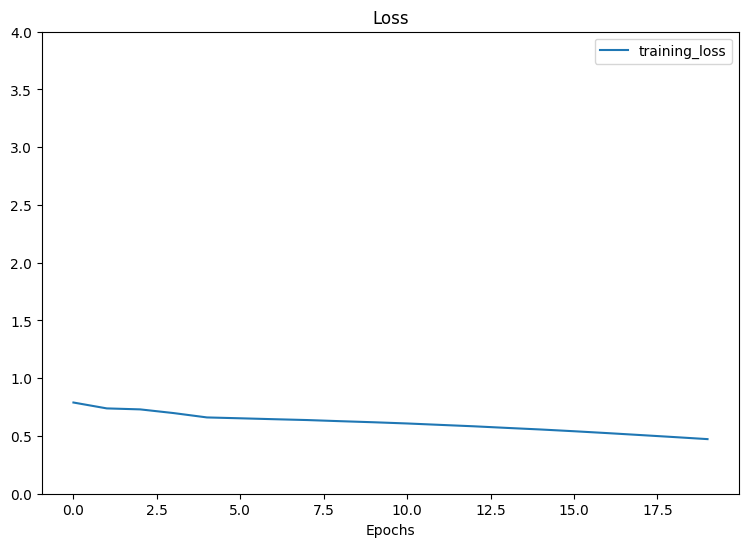

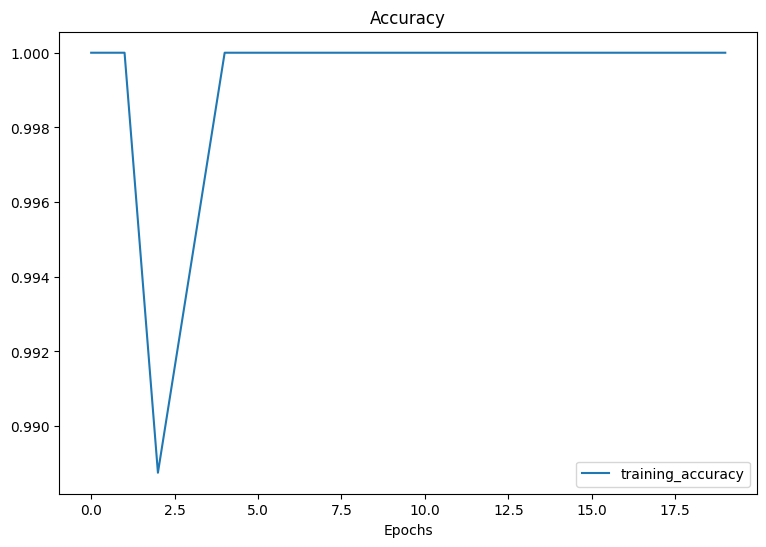

In [8]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

cosine_scheduler = False # Set to True if using cosine decay, False if using fixed learning rate

train_for_more_epochs = True
BEST_NUM_EPOCHS = 20 # number of epochs for training

# Hyperparameters
BEST_LR = 1.1e-5 # learning rate
BEST_REG= 2e-4 # l2 regularization factor

# Cosine decay parameters
DECAY_STEPS_TO_USE = math.ceil(len(train_data) / BATCH_SIZE) * 100 # 100 epochs (used in cross-validation for cosine decay)
BEST_ALPHA_FACTOR =  1e-6 / BEST_LR
DROPOUT_RATE = 0.0
cosine_decay = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=BEST_LR,
                                                        decay_steps=DECAY_STEPS_TO_USE,
                                                        alpha=BEST_ALPHA_FACTOR,
                                                        name='CosineDecay')


model = Resnet3DBuilder.build_resnet_34((91, 109, 91, 1), 1, reg_factor=BEST_REG, dropout_rate=DROPOUT_RATE)
if train_for_more_epochs:
    model.load_weights("/home/diogommiranda/tese/outputs/best_model.weights.h5") # load model to continue training for more epochs
    print(f"\nLoading model weights to continue training for more epochs.")
        

if cosine_scheduler:
    # Use cosine decay
    optimizer_lr = cosine_decay
    print(f"\nUsing cosine decay.\n")
else:
    # Use fixed learning rate
    optimizer_lr = BEST_LR
    print(f"\nUsing fixed learning rate: {BEST_LR}\n")

auc_metric = tf.keras.metrics.AUC(name='auc')

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=optimizer_lr, clipnorm=1.0),
                metrics=["accuracy", auc_metric])


# Only save the model if not using cosine decay
if not cosine_scheduler:
    check_point_filepath = "/home/diogommiranda/tese/outputs/best_model.weights.h5"
    print(f"Saving model to: {check_point_filepath}")
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=check_point_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=False)
    callbacks = [model_checkpoint_callback]
else:
    callbacks = None

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
class_weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=train_labels)
class_weight_dict = dict(zip(unique_classes, class_weights))
print(f"  Class Weights: {class_weight_dict}")

history = model.fit(
    train_data,
    epochs=BEST_NUM_EPOCHS,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=callbacks
)

# Plot loss and accuracy curves
plot_loss_curves(history)

result = model.evaluate(test_data, return_dict=True)
print(f"[{result['loss']}, {result['accuracy']}]")


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step


2025-05-06 23:07:03.153964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



--- Evaluation Metrics on Test Set ---
Accuracy:    0.8100
Sensitivity: 0.8077
Specificity: 0.8112 
Balanced Accuracy (BACC): 0.8094
F1 Score (Weighted):      0.8126
Matthews Corr Coef (MCC): 0.6020
Area Under the Curve (AUC): 0.8759



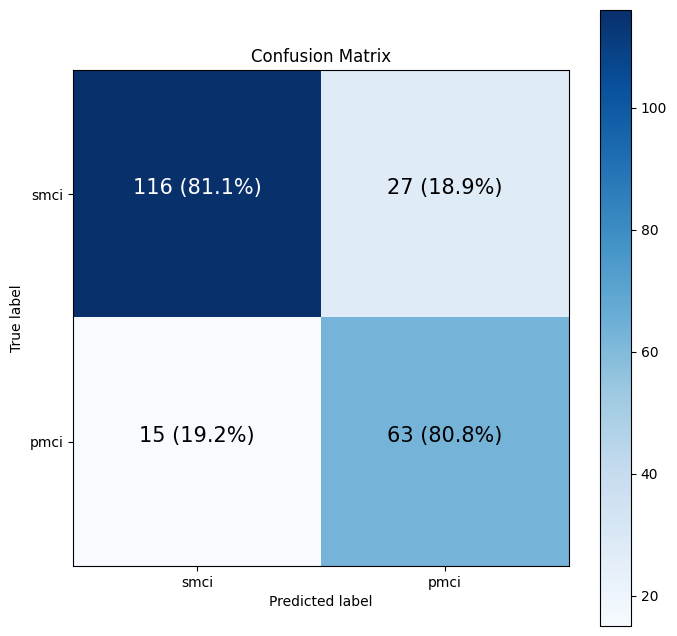

In [9]:
# Predict on the test set
y_pred = model.predict(test_data).flatten()

# --- Print evaluation metrics ---
y_true = []
test_samples = []
for sample, label in test_data.as_numpy_iterator():
    test_samples.append(sample)
    y_true.append(label)
y_true = np.concatenate(y_true)


test_samples = np.concatenate(test_samples, axis=0)
y_true_int = y_true.astype(int)
y_pred_int = y_pred.round().astype(int)

# y_pred_int = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_true_int, y_pred_int)
sensitivity = recall_score(y_true_int, y_pred_int, pos_label=1)
specificity = recall_score(y_true_int, y_pred_int, pos_label=0)
bacc = balanced_accuracy_score(y_true_int, y_pred_int)
f1 = f1_score(y_true_int, y_pred_int, average='weighted')
mcc = matthews_corrcoef(y_true_int, y_pred_int)

auc_score = result.get('auc')

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

# --- Plot confusion matrix ---
class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred.round(),
                      classes=target_names,
                      figsize=(8, 8),
                      text_size=15)



# Save the model

In [ ]:
save_option = False # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
    
    # Configure the right path
    if USE_MASK:
        dir1 = "masked/"
    else:
        dir1 = "full_brain/"
    if cosine_scheduler:
        dir2 = "cosine_decay/"
    else:
        dir2 = "fixed_lr/"
        
    save_model_dir = "/home/diogommiranda/tese/outputs/" + dir1 + dir2 + "CROSS_VALIDATION/saved_models/" + f"LR={BEST_LR:.1e}_L2={BEST_REG:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    model.save(os.path.join(save_model_dir, "model.keras"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"[{result['loss']}, {result['accuracy']}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

Saving model to: /home/diogommiranda/tese/outputs/masked/fixed_lr/CROSS_VALIDATION/saved_models/LR=1.1e-05_L2=2e-04


In [ ]:
#saved_model = tf.keras.models.load_model("/home/diogommiranda/tese/outputs/full_brain/fixed_lr/CROSS_VALIDATION/saved_models/LR=1.1e-5 L2=2e-4/model.keras")

In [ ]:
#result = saved_model.evaluate(test_data, return_dict=True)
#print(f"[{result['loss']}, {result['accuracy']}]")


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.8917 - auc: 0.3368 - loss: 1.7163
[1.964396357536316, 0.8461538553237915]
